In [2]:
from tqdm import tqdm_notebook
import numpy as np
import deepdish as dd
import os
import h5py
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
# from _classification_util import *
from _mempal_util import nSubj, nItems, create_dirs, save_obj, RoomObjectIdxToNames
# from _searchlight_util import *
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar sizing


# Room Reliability

In [3]:
def ExtractRoom2RoomResults(roi,roi_ids,hems=['L','R'], measures=['reliability'], reliability_dir = '../PythonData2024/Output/room2room'):
    
#     nPerm =1000
    
    # measures = 'reliability' # 'distinctiveness' , 'stability'
#     reliability_dir = '../PythonData2024/Output/room2room' #should be RoomReliability    
    vals = {}
   
    ## grab one of these: (dict_keys(['corrmat', 'distinctiveness', 'reliability', 'reliability_loo_isc', 'room2room', 'stability']))
    for measure in measures:
        vals[measure] = {}
        
        for hem in hems:
            vals[measure][hem] = {}

            if measure == 'corrmat':
                vals[measure][hem] = np.full((len(roi_ids),nItems,nItems,nSubj), fill_value=np.nan)
                
            if measure == 'reliability' or measure =='distinctiveness' or measure == 'stability':
                vals[measure][hem] = np.full((len(roi_ids),nItems,nSubj,nPerm+1), fill_value=np.nan)
                
            if measure == 'diffs': #it's the same as "reliablity", but with "items/rooms" already averaged
                vals[measure][hem] = np.full((len(roi_ids),nSubj), fill_value=np.nan)

            for i,roi_id in enumerate(tqdm_notebook(roi_ids)):
                fname = '{}_{}{:03d}_{}_RoomReliability.h5'.format(date,roi,roi_id,hem)

                if measure == 'diffs':
                    vals[measure][hem][i,:] = dd.io.load(os.path.join(reliability_dir,fname),group='/{}/{}'.format('room2room',measure))

                else:
                    vals[measure][hem][i] = dd.io.load(os.path.join(reliability_dir,fname),group='/{}'.format(measure))

                
    return vals
                
    

In [4]:
rois = ['hippo','ahippo','phippo']
roi_ids = [9999]
nPerm = 1000
date = 20240108
reliability_dir = '../PythonData2024/Output/room2room'

hems = ['None']

scores = {}
for roi in rois:
    scores[roi] = ExtractRoom2RoomResults(roi,roi_ids,hems=hems, 
                                          measures=['reliability','distinctiveness','corrmat', 'diffs'],
                                         reliability_dir = reliability_dir)
    

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

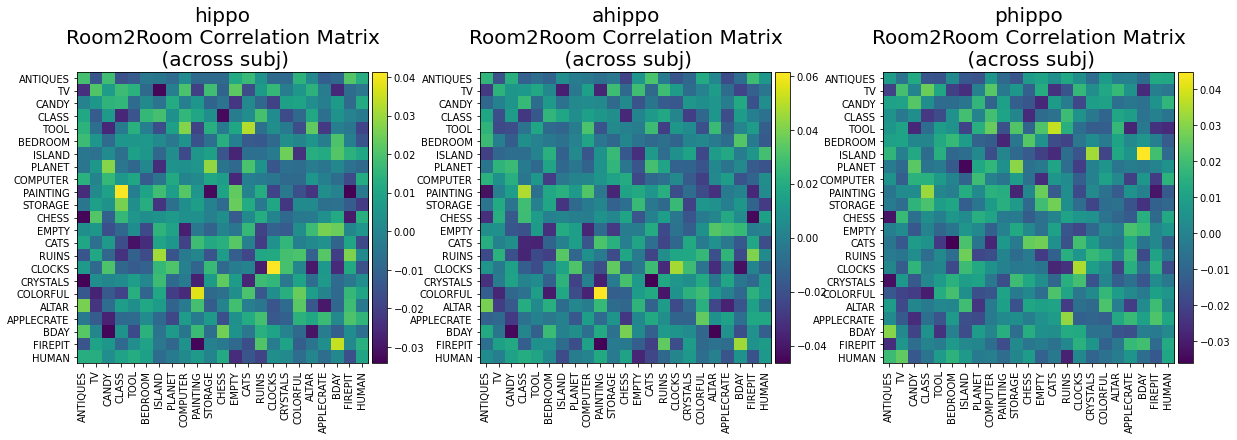

In [5]:
room_names = [RoomObjectIdxToNames[i] for i in range(1,24)]

fig,ax = plt.subplots(1,3, figsize=(20,20))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=None)
fig.subplots_adjust(wspace=.3)

for i,roi in enumerate(rois):
    corrmat = scores[roi]['corrmat']['None'].squeeze()
    
    im = ax[i].imshow(corrmat.mean(2))
    ax[i].set_title("{}\nRoom2Room Correlation Matrix\n (across subj)".format(roi), fontsize=20)
    ax[i].set_xticks(range(23))
    ax[i].set_yticks(range(23))
    ax[i].set_xticklabels(room_names, rotation=90)
    ax[i].set_yticklabels(room_names)
    
    # right side color bar | 5% of ax | padding between cax and ax fixed at 0.05 inch   
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)




# reliability

(23, 25, 1001)
0.005557797371281526 0.005557797371281526
(23, 25, 1001)
0.004548730816269788 0.004548730816269788
(23, 25, 1001)
0.006390309518688251 0.00639030951868825


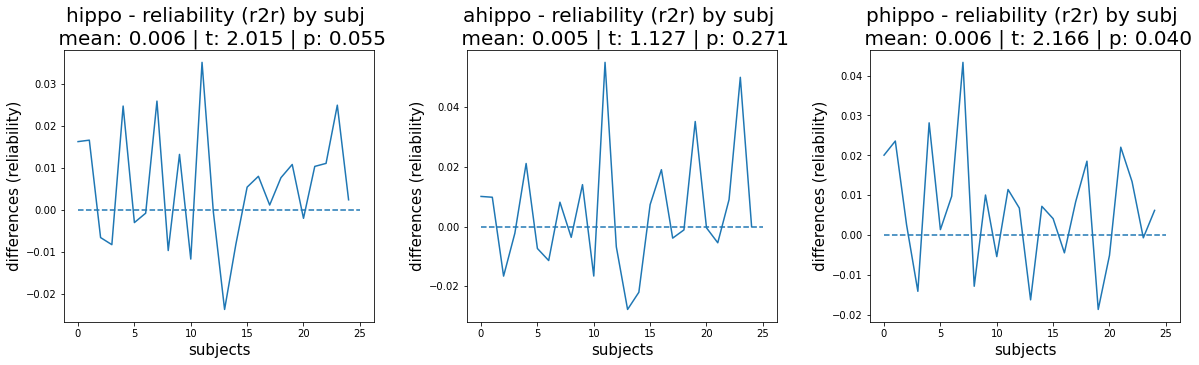

In [6]:
fig,ax = plt.subplots(1,3, figsize=(20,5))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=None)
fig.subplots_adjust(wspace=.3)

for i,roi in enumerate(rois):
    rel = scores[roi]['reliability']['None'].squeeze()
    print(rel.shape)
    rel = rel.mean(0)[:,0] #grab subjects and average room reliabilities
    print(rel.mean(),scores[roi]['diffs']['None'].mean())
    
    t,p = stats.ttest_1samp(rel,0)

    ax[i].plot(rel)
    ax[i].set_xlabel("subjects", fontsize=15)
    ax[i].set_title("{} - reliability (r2r) by subj \n mean: {:.3f} | t: {:.3f} | p: {:.3f}".format(roi,
                                                                                                    scores[roi]['diffs']['None'].mean(),
                                                                                                    t,
                                                                                                    p), fontsize=20)
    ax[i].set_ylabel('differences (reliability)',fontsize=15);
    ax[i].hlines(0,0,25,linestyle='--')
    
    

    

## Reliability Permutation test

In [10]:
rois

['hippo', 'ahippo', 'phippo']

1.812872609715721 0.034925735834710134
-1.8128726097157206 0.9650742641652899
1.1713787762873327 0.12072327969651436
-1.1713787762873324 0.8792767203034856
2.166972355283107 0.015118481049163033
-2.166972355283107 0.984881518950837


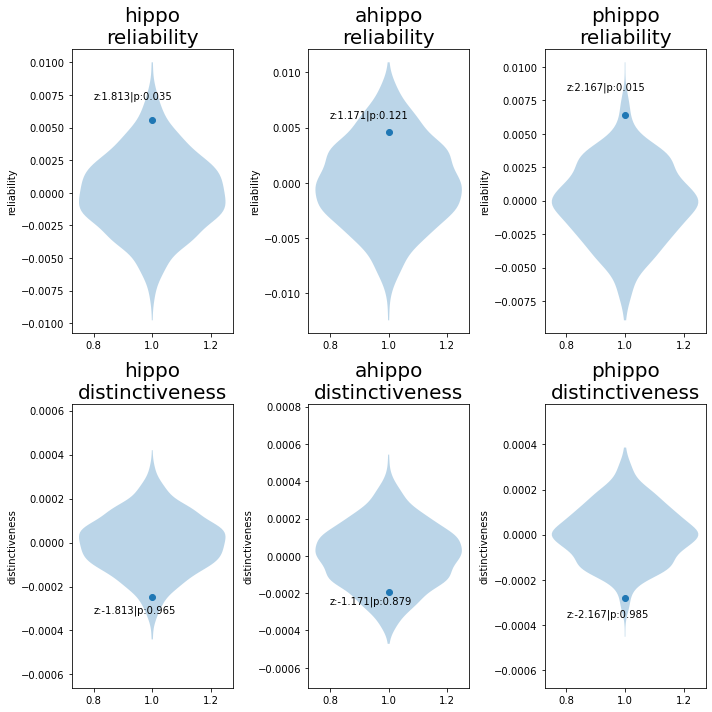

In [12]:
fig,ax = plt.subplots(2,3, figsize=(10,10))
for i,roi in enumerate(rois):
    for j,measure_key in enumerate(['reliability','distinctiveness']):

        true_mean = scores[roi][measure_key]['None'].squeeze().mean(0).mean(0)[0]
        null =  scores[roi][measure_key]['None'].squeeze().mean(0).mean(0)[1:]
        null_mean = null.mean()
        null_std = null.std()
        
        z = (true_mean - null_mean) / null_std
        p = stats.norm.sf(z)
        
        print(z,p)

        ax[j,i].scatter(1, true_mean)
        ax[j,i].violinplot(null, showextrema=False)
        ax[j,i].set_title("{}\n{}".format(roi,measure_key),fontsize=20)
        ax[j,i].set_ylabel(measure_key)
        
#         ax[j,i].annotate("z:{:.3f}|p:{:.3f}".format(z,p), (1-.2, (true_mean+(true_mean*.5))))
        ax[j,i].annotate("z:{:.3f}|p:{:.3f}".format(z,p), (1-.2, (true_mean+(true_mean*.3))))

        
        if measure_key == 'distinctiveness':
            ax[j,i].set_ylim([null.min()+null.min()*.5,null.max()+null.max()*.5])
        
plt.tight_layout()



# does hippo room reliability correlate with ROCN obj reinstatement?


In [120]:
rois

['hippo', 'ahippo', 'phippo']

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

hippo
-0.5660915832525516 0.7143342376865981
ahippo
-0.3120731031946885 0.6225075164940002
phippo
-0.6899164109406942 0.7548766225213233


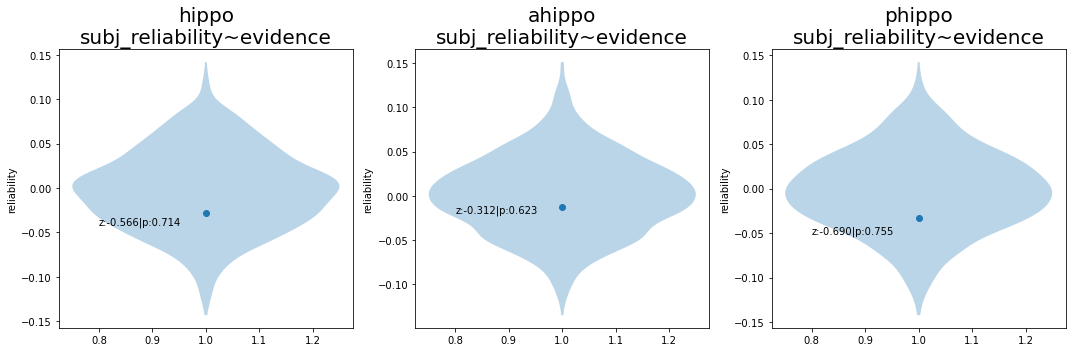

In [6]:
###
### LOAD NETWORK EVIDENCE from RECALL (this is going to be the same for all searchlights)
###
from _mempal_util import load_obj, subject_ids

network = 'ROCN' # <--------- CHANGE THIS to see results for others
trial_type = 'GR' # <--------- CHANGE THIS to see results for others
measure_key = 'reliability'
shift = 4
top_thresh = 50
nPerm =1000

# RIP_date             = 20240108 # recalled item evidence (RIP: recalled item probability)
RIP_date             = 20240401 # second permutation fix / recalled item evidence (RIP: recalled item probability)

network_evidence_dir = "../PythonData2024/Output/RecallEvidence"

fname                = '{}_NetworksRecallEvidence_shift{}_top{}.pkl'.format(RIP_date,shift,top_thresh)

network_evidence = load_obj(os.path.join(network_evidence_dir,fname))
item_evidence    = network_evidence[network][trial_type] #ROCN or POCN evidence for GR or FR 

################################################################
################################################################

#####
##### Reliability ~ Object Evidence (ROCN or POCN)
#####

# Run the correlation between room reliability and item evidence within recall networks

anas = {} # 'anas' == 'analyses'

for hi, hipporoi in enumerate(rois):
    anas[hipporoi] = {}
    subj_analysis  = 'subj_{}~evidence'.format(measure_key)  # reliability ~ evidence || stability ~ evidence, etc
    anas[hipporoi][ subj_analysis ]  = np.zeros((nSubj,nPerm+1))

    for si,subj in tqdm_notebook(enumerate(subject_ids)):

        ## get the reliability
        subj_reliability  = scores[hipporoi][measure_key]['None'].squeeze()[:,si,0] #room_reliability[:,si]

        ## get the item evidence for this subj
        subj_evidence = item_evidence[:,si] # 23 numbers

        ## gather the nans
        nonnans = ~np.isnan(subj_evidence)

        # ** room reliabity ~ object evidence ** 
        anas[hipporoi][ subj_analysis ][si,0]  = stats.pearsonr(subj_reliability[nonnans],subj_evidence[nonnans])[0]

        for p in range(nPerm):

            sortidx = np.random.permutation(nItems)

            subj_reliability_perm  = subj_reliability.copy()[sortidx]

            anas[hipporoi][ subj_analysis ][si,p+1]  = stats.pearsonr(subj_reliability_perm[sortidx][nonnans],
                                                                       subj_evidence[nonnans])[0]

            
#### PLOT PLOT PLOT
fig,ax = plt.subplots(1,3, figsize=(15,5))
for i,roi in enumerate(rois):
    print(roi)
    for j,measure_key in enumerate(['reliability']):
    
        true_mean = np.arctanh(anas[roi][subj_analysis]).mean(0)[0] #scores[roi][measure_key]['None'].squeeze().mean(0).mean(0)[0]
        null =  np.arctanh(anas[roi][subj_analysis]).mean(0)[1:]
        null_mean = null.mean()
        null_std = null.std()
        
        z = (true_mean - null_mean) / null_std
        p = stats.norm.sf(z)
        
        print(z,p)

        ax[i].scatter(1, true_mean)
        ax[i].violinplot(null, showextrema=False)
        ax[i].set_title("{}\n{}".format(roi,subj_analysis),fontsize=20)
        ax[i].set_ylabel(measure_key)
        
        ax[i].annotate("z:{:.3f}|p:{:.3f}".format(z,p), (1-.2, (true_mean+(true_mean*.5))))
        
        if measure_key == 'distinctiveness':
            ax[j,i].set_ylim([null.min()+null.min()*.5,null.max()+null.max()*.5])
        
plt.tight_layout()



# does hippo room reliability correlate with any of the SLs room reliability?

(perhaps SL room reliability is the mediator?)



In [114]:
scores.keys()

dict_keys([])

In [17]:
# measure_key = 'reliability' # 'distinctiveness' , 'stability'
reliability_date = 20240108
reliability_dir  = '../PythonData2024/Output/room2room' #room reliability

measure_key = 'reliability'

hipporois = ['hippo','phippo','ahippo']
###

r_corrs = {}
for hi, hipporoi in enumerate(hipporois):
    r_corrs[hipporoi] = {}
    for hem in ['L','R']: #['L','R']:
        r_corrs[hipporoi][hem] = np.zeros((1483))
        for roi_id in tqdm_notebook(range(1483)):
            
            fname            = '{}_SL{:03d}_{}_RoomReliability.h5'.format(reliability_date,roi_id,hem)
            sl_room_reliability = dd.io.load(os.path.join(reliability_dir,fname),group='/{}'.format(measure_key))[:,:,0] # (nItems,nSubj)
            
            hippo_room_reliability = scores[hipporoi]['reliability']['None'].squeeze()[:,:,0] # (23,25)
            
            
            r_corrs[hipporoi][hem][roi_id] = stats.pearsonr(sl_room_reliability.mean(0), hippo_room_reliability.mean(0))[0]
            
        
        
        

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

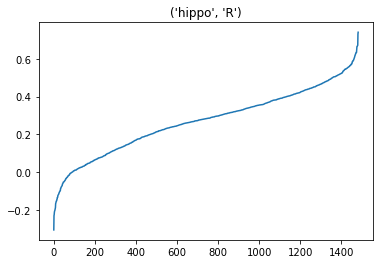

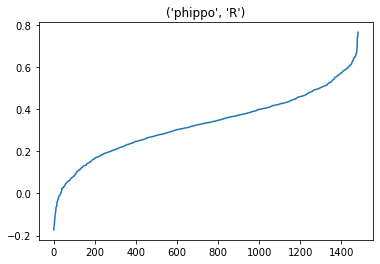

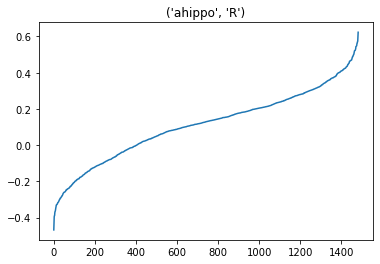

In [10]:
for hi, hipporoi in enumerate(hipporois):
    plt.figure()
    plt.title(tuple((hipporoi,hem)))
    plt.plot(np.sort(r_corrs[hipporoi][hem]))
    

In [20]:
best = np.where(r_corrs['phippo'][hem]>0.60)[0]
print(len(best), hem)
[print(i, end=',') for i in best];

best = np.where(r_corrs['phippo']['L']>0.60)[0]
print()
print(len(best), 'L')
[print(i, end=',') for i in best];

48 R
59,72,89,140,202,221,226,235,236,281,338,339,407,419,472,491,608,609,638,662,665,666,683,763,818,853,856,865,891,958,959,1012,1035,1036,1037,1126,1131,1148,1150,1196,1236,1240,1291,1294,1343,1368,1369,1466,
83 L
24,26,36,50,98,107,141,144,145,181,209,216,221,241,244,266,269,272,291,303,307,336,394,426,491,518,522,574,577,579,580,581,586,648,655,656,657,676,677,678,711,724,763,764,806,812,813,855,861,902,903,915,917,918,926,927,943,995,1019,1057,1068,1092,1096,1144,1150,1153,1173,1215,1242,1243,1247,1263,1396,1397,1398,1402,1403,1404,1411,1412,1476,1477,1481,

In [35]:
# # for GRs
# best_R = np.array([1416,  767,  850,  272,  986, 1469,  985, 1010,  984,  983,  849,
#            206,  353,  208, 1052,  244, 1051,  209, 1238, 1237,  407,  976,
#            621,  281, 1148,  253,  891,   63,  975,  987, 1240, 1012,  349,
#           1410,  325, 1164,  939,  847, 1155,  910, 1332,  521, 1411,  132,
#            147, 1419,  854, 1333, 1239,  755,  934,  104, 1124, 1094, 1167,
#            583,    0,  799,   86,  857, 1452,  507, 1337,   17,  271,  429,
#            638, 1217,  756,  292,   64, 1129,  695,  881, 1334,  592,  699,
#           1147, 1304,  836,  258,  312,  584, 1127,  643,  290,  698,  181,
#            916,  488, 1218, 1056, 1420,  556,  557, 1128,  354,  821,   53,
#            862])

# # FOR FRs
# # best_R = np.array([ 866,  131,   35,  392, 1305,  972,   46,  971,  328,  673, 1306,
# #            792,  234, 1400,  254, 1463,   17,  501, 1026,  220,  746,  444,
# #           1170, 1307,   29,  754,   44,  873,  219, 1127,   19,   85,  206,
# #            671,  120,  203, 1411,  347,   21,  391, 1002,  556,  117,  348,
# #            204,  172,  575,  847,  744,  756,  962, 1080,  848, 1332,   13,
# #             50, 1212,  890,  576,  199,  742, 1420,  124, 1410,  118,   52,
# #           1185, 1184, 1123,  963,   60, 1183,  500,  271,  384,  476,  443,
# #           1003,  705,  975, 1252,  987,  597, 1010,  799,  745, 1239,  755,
# #            383,   59, 1341,  748,  707,  155,  145, 1396,  936, 1399,  791,
# #           1211]) 

In [88]:
# intersection = set(best).intersection(set(best_R))

In [89]:
# intersection

{281, 407, 638, 891, 1012, 1148, 1240}

In [43]:
# anas[roi][subj_analysis].shape

(25, 1001)

## does hippo reliability\~evidence results correlate with SL reliability\~evidence results?

In [147]:
# roi = 'SL'
# hems=['L','R']
# nPerm = 1000
# nSubj =25
# nRooms = 23
# nItems=23
# nTrials = 23

# from _searchlight_util import SLlist

# rois = []

# measure_list = ['subj_{}~evidence'.format(measure_key)] #,'group_{}~evidence'.format(measure_key), 'm0_r2','m1_r2',]

# date = 20240401 # second permutation test fix

# SL_scores = {}
# for network in ['ROCN']:#,'POCN']:
#     SL_scores[network]  = {}
#     for trial_type in ['GR','FR']:#,'FR']:
#         SL_scores[network][trial_type] = {}
#         for measure in measure_list:
#             SL_scores[network][trial_type][measure] = {}
            
#             for hem in ['R']:#['L','R']:
        
#                 # if a correlation
#                 if '~' in measure:
#                     SL_scores[network][trial_type][measure][hem] = np.zeros((len(SLlist[hem]),nSubj, nPerm+1))

#                 if 'm0' or 'm1' in item: # for coeffs and aic
#                     SL_scores[network][trial_type][measure][hem] = np.zeros((len(SLlist[hem]), nSubj, nPerm+1))



#                 for roi_id in tqdm_notebook(range(len(SLlist[hem]))[:]):
#                     savedir = '../PythonData2024/Output/Reliability2Evidence'
#                     filename = '{}_{}{:03d}_{}_{}2evidence_{}_{}'.format(date,roi,roi_id,hem,measure_key,network,trial_type) + '.h5'
#                     fullpath = os.path.join(savedir, filename)

#                     SL_scores[network][trial_type][measure][hem][roi_id] =  dd.io.load(fullpath,'/{}'.format(measure))

 



/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:80: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

In [44]:
# scores[roi][measure_key]['None'].squeeze().shape

(23, 25, 1001)

In [95]:
# np.nanmean(scores['ROCN']['GR']['subj_reliability~evidence']['R'][:,:,0], 1).shape

(1483,)

In [170]:
# best_new = np.where(np.nanmean(SL_scores['ROCN']['GR']['subj_reliability~evidence']['R'][:,:,0], 1)<-0.07)[0]
# len(best_new)

73

In [171]:
# set(best).intersection(set(best_new))

set()

In [172]:
# best,best_new

(array([ 165,  224,  290,  911, 1154, 1390, 1457]),
 array([   9,   66,   81,  167,  182,  183,  214,  257,  302,  311,  313,
         317,  355,  358,  360,  361,  376,  396,  457,  458,  473,  519,
         560,  566,  612,  632,  647,  648,  669,  685,  703,  784,  805,
         808,  809,  823,  873,  897,  917,  929,  942,  962,  963,  992,
        1013, 1014, 1062, 1085, 1095, 1096, 1098, 1130, 1139, 1151, 1168,
        1183, 1184, 1185, 1219, 1228, 1245, 1248, 1249, 1308, 1309, 1328,
        1339, 1342, 1357, 1424, 1437, 1476, 1477]))

# does hippo make it into the ROCN or POCN teams?

The answer: no. 

In [11]:
from _mempal_util import subject_ids, room_obj_assignments
from _classification_util import Convert_SourceItem_to_PairedItem_Order
from _searchlight_util import *


### (1) functions for import (modified to allow for hippo in addition to SLs)

In [12]:
betatypes = ['rooms','objects']
videotypes = ['rooms','objects']
hem_label='None'#'both'
betatype_label='both'
win_size=9
shift=4
hems = ['None']



def GetItemSpecificTimepoints(event_mat):
    '''
    For an EventMat (nTRs, nItems), get the exact timepoints they talk about the each item in the eventmat.
    
    Use these timepoints for average the CPs.
    
    NOTE NOTE NOTE: this gives me OVERALL timepoints for any event, so if they talk about an event more than once non-contiguously,
    then, that will get averaged all together. IF I want to get the timepoints separated non-contiguously, I have to write another
    function that will do that. This just gives me all the numbers.
    
    '''
    
    timepoints = np.where(event_mat==1)[0] # timepoints where events happen
    items_in_time = np.where(event_mat==1)[1] # the events/items 
    
    unique_items = np.unique(items_in_time)
    
    items_and_times_dict = {}
    
    for item_key in unique_items:
        
        # where is there timepoints for this event?
        items_and_times_dict[item_key] = np.where(event_mat[:,item_key]==1)
        
    return items_and_times_dict

def ImportROV12(date,task_id,betatypes,videotypes,measure_list, roi='SL', hems=['L','R']):
#     roi = 'SL'
    
    TR_crop = 212
    nPerm = 1000

    scores = {}


    for betatype in tqdm_notebook(betatypes):
        scores[betatype] = {}

        for videotype in videotypes:
            scores[betatype][videotype] = {}

            for measuretype in tqdm_notebook(measure_list):
                scores[betatype][videotype][measuretype] = {}


                for hem in hems:

                    ###
                    ### Specific initiation for different array shapes
                    ###
                    
                    nROIs = len(SLlist[hem]) if roi=='SL' else 1

                    if 'normal' == measuretype or 'current_room' == measuretype or 'prev_room'==measuretype or 'next_room'==measuretype:
                        scores[betatype][videotype][measuretype][hem] = np.zeros((nROIs,27, nSubj))

                    if 'accuracy' ==measuretype:
                        scores[betatype][videotype][measuretype][hem] = np.zeros((nROIs,nSubj,nPerm+1))

                    if 'conf_mat' == measuretype:
                        scores[betatype][videotype][measuretype][hem] = np.zeros((nROIs,nItems,nItems,nSubj))

                    if 'event_mats_all' == measuretype:
                        scores[betatype][videotype][measuretype][hem] = np.zeros((TR_crop,nItems,nSubj))

                    if 'y_probs' in measuretype:
                        scores[betatype][videotype][measuretype][hem] = np.zeros((nROIs,TR_crop,nItems, nSubj))


                    ###
                    ### Load the saved .h5 files
                    ###
                    roi_ids = range(len(SLlist[hem])) if roi=='SL' else [9999]
                    for ri,roi_id in enumerate(tqdm_notebook(roi_ids)):

                        fname = '{}_{}{:03d}_hems{}_betas{}_winsize{}_shift{}_ClassifyVideos'.format(
                        date,
                        roi,
                        roi_id,
                        hem_label,
                        betatype_label,
                        win_size,
                        shift) + '.h5'

                        fullpath = os.path.join(dirpath,fname)

                        if 'normal' == measuretype or 'current_room' == measuretype or 'prev_room'==measuretype or 'next_room'==measuretype:

                            # (27, nSubj, 23 transitions) 
                            temp = dd.io.load(fullpath,'/{}/{}/{}/{}'.format(betatype,videotype,hem,measuretype))
                            temp = np.nanmean(temp,axis=2) #average out the 23 transitions
                            scores[betatype][videotype][measuretype][hem][ri,] = temp 
                            
                        elif 'event' in measuretype:
                            scores[betatype][videotype][measuretype][hem] = dd.io.load(fullpath,'/{}/{}/{}/{}'.format(betatype,videotype,hem,measuretype))
                            
                        else:
                            scores[betatype][videotype][measuretype][hem][ri] = dd.io.load(fullpath,'/{}/{}/{}/{}'.format(betatype,videotype,hem,measuretype))

    return scores



def GetCPsFromROV1or2(scores,ReOrderCPs=False, roi='SL',hems=['L','R']):
    '''get CPs from averaging CPs from classifier evidence using event_mat'''
    
    for betatype in betatypes:
        print("BETATYPE: ", betatype)

        for videotype in videotypes:
            print("...VIDEOTYPE: ", videotype)

            for measuretype in ['CPs']:
                scores[betatype][videotype]['CPs'] = {}

                for hem in hems:
                    print(".......HEM: ", hem)
                    
                    nROIs =  len(SLlist[hem]) if roi=='SL' else 1
                    scores[betatype][videotype]['CPs'][hem] = np.full((nROIs,nItems,nSubj),fill_value=np.nan)

                    for si, subj in enumerate(subject_ids):

                        ## event_mats --> (1483, 212, 23, 25)
                        this_evmat = scores[betatype][videotype]['event_mats_all'][hem][:,:,si] #(212,23,25) --> TR_crop,nItems,nSubj

                        ## (1483, 212, 23, 25), index 1 is current, 0 and 2 are past and next respectively
                        current_evidence =  scores[betatype][videotype]['y_probs'][hem][:,:,:,si] # (nSLs, nTRs)

                        ###
                        ### Collect Overall CP Score for Event (not using window)
                        ### 

                        items_and_times_dict = GetItemSpecificTimepoints(this_evmat)
                        for item in items_and_times_dict.keys():
                            ts = items_and_times_dict[item] # timepoints
                            current_cps = current_evidence[:,ts,item] # index the timepoints and the item of interest
        #                     print(current_cps.shape)
                            scores[betatype][videotype]['CPs'][hem][:,item,si] = np.nanmean(np.nanmean(current_cps,1),1) #these cps are not ordered by subj assignment.

                ####
                #### RE-ORDER object CPs to the room -> object pairing for each subject
                ####
                if ReOrderCPs == True:
                    scores[betatype][videotype]['CPs_bySubj'] = {'L':[],'R':[],'None':[]}
                    reordered_cp_hem = {'L':[],'R':[],'None':[]}
                    
                    if roi =='SL':
                        cp_hem_L = scores[betatype][videotype]['CPs']['L']
                        cp_hem_R = scores[betatype][videotype]['CPs']['R']
                        reordered_cp_hem['L'] =  np.full((len(SLlist['L']),nItems,nSubj), fill_value=np.nan)
                        reordered_cp_hem['R'] =  np.full((len(SLlist['R']),nItems,nSubj), fill_value=np.nan)
                    else:
                        cp_hem = scores[betatype][videotype]['CPs']['None']
                        reordered_cp_hem['None'] = np.full((len([9999]),nItems,nSubj), fill_value=np.nan)
    
                    item_order = np.arange(nItems)
                    for si, subj in enumerate(subject_ids):

                        if betatype == 'rooms':
                            #no need to re-order
                            print("no need to re-order ", end=',')

                            new_item_order = item_order

                        elif betatype == 'objects':

                            # need to re-order so that object index is equal to room index per subject
                            new_item_order = Convert_SourceItem_to_PairedItem_Order(subj,item_order,room_obj_assignments,fromItem='objidx',toItem='roomidx')
                        
                        if roi =='SL':
                            reordered_cp_hem['L'][:,:,si] = cp_hem_L[:,new_item_order,si] # for getting ordered cps but per hemisphere
                            reordered_cp_hem['R'][:,:,si] = cp_hem_R[:,new_item_order,si] # for getting ordered cps but per hemisphere
                        else:
                             reordered_cp_hem['None'][:,:,si] = cp_hem[:,new_item_order,si]
                    if roi=='SL':
                        scores[betatype][videotype]['CPs_bySubj']['L'] = reordered_cp_hem['L']
                        scores[betatype][videotype]['CPs_bySubj']['R'] = reordered_cp_hem['R']
                    else:
                        scores[betatype][videotype]['CPs_bySubj']['None'] = reordered_cp_hem['None']
                    
    return scores


### (2) import classification scores for recalled objects and perceived objects for hippo

In [13]:
betatypes = ['objects', 'rooms']
videotypes = ['rooms', 'objects'] 

# betatypes = ['objects']
# videotypes = ['objects'] 

measure_list = [
    #     'normal', #PCN (9*3,25)
        'current_room', #PCN (9*3,25)
    #     'next_room',#PCN (9*3,25)
    #     'prev_room',#PCN (9*3,25)
        'event_mats_all',
#         'cp_results', # (212,3,25)
    #     'y_correct_probs', # (212, 25) # dont need it, because it's just cp_results and its probably empty!
#         'event_mats_all', #(212,23,25)
        'accuracy', # (25,nPerm+1)
        'conf_mat',# (23,23,25)
        'y_probs'
        ] 

# dirpath = '../PythonData2024/Output/ClassifyVideos'
dirpath = '../PythonData2024/Output/ClassifyVideos_v6'


In [14]:
### HIPPO


betatypes = ['rooms','objects']
videotypes = ['rooms','objects']
hem_label='None'
betatype_label='both'
win_size=9
shift=4


hippo_ROV1_scores = {}
hippo_ROV2_scores = {}
for hipporoi in ['ahippo','phippo','hippo']:
    print(hipporoi)
#     date = 20240108_001; task_id = 1 # ROV1 after perm fix hippo
    date = 20240401_001; task_id = 1 # ROV1 after perm fix hippo - second permutaiton fix
    hippo_ROV1_scores[hipporoi] = ImportROV12(date,task_id,betatypes,videotypes,measure_list,roi=hipporoi,hems=['None'])
    hippo_ROV1_scores[hipporoi] = GetCPsFromROV1or2(hippo_ROV1_scores[hipporoi],ReOrderCPs=True, roi=hipporoi,hems=['None'])


#     date = 20240108_002; task_id = 2 # ROV2 after perm fix hippo
    date = 20240401_002; task_id = 2 # ROV2 after perm fix hippo - second permutation fix
    hippo_ROV2_scores[hipporoi] = ImportROV12(date,task_id,betatypes,videotypes,measure_list,roi=hipporoi,hems=['None'])
    hippo_ROV2_scores[hipporoi] = GetCPsFromROV1or2(hippo_ROV2_scores[hipporoi],ReOrderCPs=True,roi=hipporoi, hems=['None'])


ahippo


/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:84: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

BETATYPE:  rooms
...VIDEOTYPE:  rooms
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,...VIDEOTYPE:  objects
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

BETATYPE:  rooms
...VIDEOTYPE:  rooms
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,...VIDEOTYPE:  objects
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

BETATYPE:  rooms
...VIDEOTYPE:  rooms
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,...VIDEOTYPE:  objects
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

BETATYPE:  rooms
...VIDEOTYPE:  rooms
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,...VIDEOTYPE:  objects
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

BETATYPE:  rooms
...VIDEOTYPE:  rooms
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,...VIDEOTYPE:  objects
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

BETATYPE:  rooms
...VIDEOTYPE:  rooms
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,...VIDEOTYPE:  objects
.......HEM:  None
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,

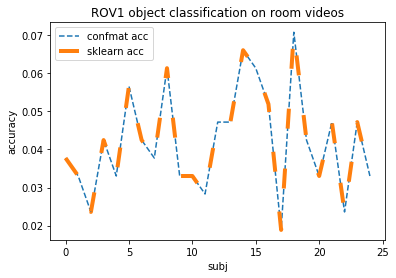

In [18]:
##### 
##### 20240411 == double checking confusion mat accuracy is the same as scikitleran score!
#####

# confusion matrix accuracy for ROV1 anterior hippo
cf = hippo_ROV1_scores['ahippo']['objects']['rooms']['conf_mat']['None'].squeeze()
x = [np.diag(cf[:,:,i]).sum()/np.sum(cf[:,:,i]) for i in range(25)]

# sklearn accuracy
y = hippo_ROV1_scores['ahippo']['objects']['rooms']['accuracy']['None'].squeeze()[:,0]

# plt.scatter(x,y);plt.tight_layout()
plt.figure()
plt.plot(x,linestyle='--',label='confmat acc'); plt.plot(y, linestyle=(0, (5, 10)),label='sklearn acc', linewidth=4)
plt.ylabel('accuracy'); plt.xlabel("subj");plt.title("ROV1 object classification on room videos");
plt.legend();

### (3) import classification scores for recalled objects and perceived objects for SLs

this is so that we have all the scores and we can compare.

In [62]:
roi

'phippo'

In [182]:

measure_list = [
    #     'normal', #PCN (9*3,25)
        'current_room', #PCN (9*3,25)
    #     'next_room',#PCN (9*3,25)
    #     'prev_room',#PCN (9*3,25)
#         'event_mats_all',
#         'cp_results', # (212,3,25)
    #     'y_correct_probs', # (212, 25) # dont need it, because it's just cp_results and its probably empty!
        'event_mats_all', #(212,23,25)
        'accuracy', # (25,nPerm+1)
    #     'conf_mat'# (23,23,25)
        'y_probs'
        ] 

roi = 'SL'
betatypes = ['rooms','objects']
videotypes = ['rooms','objects']
hem_label='both'
betatype_label='both'
win_size=9
shift=4


##second permutation fix
date = 20240401001 ; task_id = 1 #for ROV1; task_id = 1
ROV1_scores = ImportROV12(date,task_id,betatypes,videotypes,measure_list,)
ROV1_scores = GetCPsFromROV1or2(ROV1_scores,ReOrderCPs=True)


### second permutation fix
date = 20240401002; task_id = 2 #for ROV2; task_id = 2
ROV2_scores = ImportROV12(date,task_id,betatypes,videotypes,measure_list)
ROV2_scores = GetCPsFromROV1or2(ROV2_scores,ReOrderCPs=True)



/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4 [00:00<?, ?it/s]

/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:84: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

BETATYPE:  rooms
...VIDEOTYPE:  rooms
.......HEM:  L
.......HEM:  R
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,...VIDEOTYPE:  objects
.......HEM:  L
.......HEM:  R
no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-order ,no need to re-orde

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1483 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
sl_confmat_path =  '../PythonData2024/Output/confmats/20240401_SL_hemsboth_betasboth_winsize9_shift4_ClassifyRecalls_CONFMAT.pkl'

20240401_SL_hemsboth_betasboth_winsize9_shift4_ClassifyRecalls_CONFMAT.pkl


### (4) look at accuracy z-scores 

In [71]:
betatypes = ['rooms','objects']
videotypes = ['rooms','objects'] 

top_thresh = 50
measuretype = 'accuracy'

# z_thresh
############################    

##
## SUPERTEAM BASED OFF CONCATENATING HEMISPHERES and GRABBING BEST Z_SCORES
##

############################   

print('*************** METHOD TOP_Z {} simultaneous HEMISPHERES ***************'.format(top_thresh))


best_Z_SLs = {} # this is done on both hemispheres
for betatype in betatypes:
    best_Z_SLs[betatype]= {}
    
    for videotype in videotypes:  
        
        hipp_acc = {}
        hipp_acc_mean = {}
        for hipporoi in ['ahippo','hippo','phippo']:
            hipp_acc[hipporoi] = np.stack((hippo_ROV1_scores[hipporoi][betatype][videotype]['accuracy']['None'],
                                           hippo_ROV2_scores[hipporoi][betatype][videotype]['accuracy']['None']))
            hipp_acc_mean[hipporoi] = np.nanmean(hipp_acc[hipporoi],0) # 2,1,25,1001 #average out the stack
            
        

        ## ROV1 and ROV2 combo
        L_acc = np.stack((ROV1_scores[betatype][videotype]['accuracy']['L'],ROV2_scores[betatype][videotype]['accuracy']['L']))
        R_acc = np.stack((ROV1_scores[betatype][videotype]['accuracy']['R'],ROV2_scores[betatype][videotype]['accuracy']['R']))
        L_acc_mean = np.nanmean(L_acc,0) #2,nSLs,25,1001 (average out new axis)
        R_acc_mean = np.nanmean(R_acc,0) #2,nSLs,25,1001 (average out new axis)
        
        best_Z_SLs[betatype][videotype] = {}
        
#         z_thresh_list = [1.96,2.576,3.090,3.719, 4.264, 5.19] # 95%, and 99%
#         z_thresh = 6 #z_thresh_list[]

        ###
        ### GROUP LEVEL
        ###
        stacked_acc = np.vstack((L_acc_mean,R_acc_mean))
        stacked_acc = np.vstack((L_acc_mean,R_acc_mean, hipp_acc_mean['ahippo'], hipp_acc_mean['phippo'], hipp_acc_mean['hippo']))
        
        stacked_acc_mean = stacked_acc.mean(1) #average across subjects
        stacked_acc_null = stacked_acc_mean[:,1:] #grab the perms #(nSLs*2,nPerm)
        stacked_acc_null_mean = stacked_acc_null.mean(1) #grab the perms #(nSLs*2)
        stacked_acc_null_std = stacked_acc_null.std(1) #grab the perms #(nSLs*2)
        stacked_acc_true = stacked_acc_mean[:,0] #grab the true, (nSLs*2)

        ## convert SL accuracies to z-scores based on permutation
        acc_z = (stacked_acc_true - stacked_acc_null_mean) / stacked_acc_null_std

        ## what are the best SLs for this subj?
        # acc_z_best_idx = np.where(acc_z>z_thresh)[0]
        # best_for_L = acc_z_best_idx[np.where(acc_z_best_idx<1483)[0]]
        # best_for_R = acc_z_best_idx[np.where(acc_z_best_idx>=1483)[0]] - 1483
        
        acc_z_best_idx = np.argsort(acc_z)[::-1][:top_thresh]
        
        print(acc_z_best_idx)
        
        best_for_L = acc_z_best_idx[acc_z_best_idx<1483] #convert back to hem specific indexing
        best_for_R = acc_z_best_idx[(acc_z_best_idx>=1483) * (acc_z_best_idx<2966)] - 1483 # convert back to hem specicifc indexing
        hippo_best = acc_z_best_idx[acc_z_best_idx>=2966] # 1483*2 = 2966, so hippos are 2966,2967,2968
        print(len(best_for_L),len(best_for_R), hippo_best)

        best_Z_SLs[betatype][videotype]['L'] = best_for_L 
        best_Z_SLs[betatype][videotype]['R'] = best_for_R
        
        print("*** TRAIN: {} Classify on {} videos |  TOP SCORES: ***".format(betatype,videotype))
        print('.... worst z acc: {:.3f}'.format(np.sort(acc_z)[::-1][:top_thresh][-1]))
        print('.... is hippocampus in the list? :', acc_z_best_idx[acc_z_best_idx>=2966])
        
        print('.... hippo z_acc: hippo: {:.3f}, phippo: {:.3f}, ahippo: {:.3f}'.format(acc_z[2966],
                                                                                       acc_z[2967],
                                                                                       acc_z[2968]))
        print('.... Best Z Accuracy SLs: ')
        print('....', L_acc_mean[best_for_L][:,:,0].mean())
        print('....', R_acc_mean[best_for_R][:,:,0].mean())
        
        ###
        ### SUBJECT LEVEL
        ###
        
        ## ROV1 and ROV2 combo
        L_PCN = np.stack((ROV1_scores[betatype][videotype]['current_room']['L'],ROV2_scores[betatype][videotype]['current_room']['L']))
        R_PCN = np.stack((ROV1_scores[betatype][videotype]['current_room']['R'],ROV2_scores[betatype][videotype]['current_room']['R']))
        L_PCN_mean = np.nanmean(L_acc,0) #2,nSLs,25,1001 (average out new axis)
        R_PCN_mean = np.nanmean(R_acc,0) #2,nSLs,25,1001 (average out new axis)
        
        stacked_PCN = np.vstack((L_PCN_mean,R_PCN_mean))
        stacked_PCN_mean = stacked_PCN.mean(1) #average across subjects
        stacked_PCN_null = stacked_PCN_mean[:,1:] #grab the perms #(nSLs*2,nPerm)
        stacked_PCN_null_mean = stacked_PCN_null.mean(1) #grab the perms #(nSLs*2)
        stacked_PCN_null_std = stacked_PCN_null.std(1) #grab the perms #(nSLs*2)
        stacked_PCN_true = stacked_PCN_mean[:,0] #grab the true, (nSLs*2)
        
        
        
        
        



*************** METHOD TOP_Z 50 simultaneous HEMISPHERES ***************
[2228 2259 2537 2715 2306 1636 1909 2919 1830 2944 2916 2621 2883 2882
 1699 1961 2716 1545 2227 1831 2274 2475 1796 2373 2229 2920  979 1512
 2915  458 2945 2487 1973 1763 2054 1851 2784 1375  555 1374 2048 1846
  987 2960 2959 2277  903 2454  746 1976]
8 42 []
*** TRAIN: rooms Classify on rooms videos |  TOP SCORES: ***
.... worst z acc: 12.222
.... is hippocampus in the list? : []
.... hippo z_acc: hippo: 1.253, phippo: 1.040, ahippo: 0.256
.... Best Z Accuracy SLs: 
.... 0.06925707547169811
.... 0.07362758310871519
[ 729 2154 1351   10  907  178  179 2277  869 1169 1034 2789 2244  776
 1653  544  398 1345  395  594  786  917 2517 2647 1179  599  399  646
 2015 1371 1427 1341 1358   82 2183 1200 2188 2279  717 1321 2064 1267
  247  440 2121  456  545 1732  688 2898]
35 15 []
*** TRAIN: rooms Classify on objects videos |  TOP SCORES: ***
.... worst z acc: 2.398
.... is hippocampus in the list? : []
.... hippo z_

# hippo performance on recalls

In [220]:
def extract_all_diagonal_and_off_diagonals(arr, axis1, axis2):
    # Determine the size of the dimensions for which to extract off-diagonals
    dim_size = arr.shape[axis1]
    
    nTrials = arr.shape[2]
    nSubj = arr.shape[3]
#     nPerm_1 = arr.shape[4]
    
    # Initialize a list to hold all off-diagonals
    off_diagonals = []
    diagonal = 0 #np.full((nTrials,nSubj,nPerm_1), fill_value=np.nan)
    
    # Loop over all possible offsets
    for offset in range(-dim_size + 1, dim_size):
        # Skip the main diagonal
        if offset != 0:
            off_diagonal = arr.diagonal(offset=offset, axis1=axis1, axis2=axis2).sum(-1)
            off_diagonals.append(off_diagonal)
        else:
            diagonal = arr.diagonal(axis1=axis1,axis2=axis2).sum(-1) #sum the last that contains diagonal values
    
    return diagonal, off_diagonals
                            
                            

In [22]:


def GetRecallEvidence(date, roi, shift, win_size, measure_list, betatypes,hems=['L','R']):
    '''
    - grabs the whole-brain results of classifying recalls (GRs+FRs)
    - returns 'scores' which is a dict with the data in measure_list
    
    '''

    trials = ['GR0', 'GR1', 'GR2', 'GR3','GR4', 'GR5', 'GR6', 'GR7','GR8', 'GR9', 'GR10','FR']

    nPerm = 1000
    nTrials = len(trials)
    nItems = 23
    nROIs =  len(SLlist[hem]) if roi=='SL' else 1

    
    scores = {}

    for betatype in tqdm_notebook(betatypes):
        scores[betatype] = {}

        print("...BETATYPE: ", betatype)

        for measuretype in tqdm_notebook(measure_list):
            scores[betatype][measuretype] = {}

            print("............MEASURE: ", measuretype)

            for hem in hems:
                print("...............HEM: ",hem)

                hem_label = hem
                betatype_label=betatype

                ###
                ### Specific initiation for different array shapes
                ###

                if 'RIP_window' == measuretype:
                    scores[betatype][measuretype][hem] = np.zeros(((nROIs,win_size,nTrials,nSubj))) 

                if 'evidence_window' == measuretype:
                    scores[betatype][measuretype][hem] = np.zeros(((nROIs,win_size,nItems, nTrials,nSubj))) 

                if 'accuracy' == measuretype:
                    scores[betatype][measuretype][hem] = np.zeros(((nROIs,nTrials,nSubj,nPerm+1)))

    #             if 'real_minus_prior' == measuretype:
    #                 scores[betatype][measuretype][hem] = np.zeros(((len(SLlist[hem]),nTrials,nSubj)))   

                if 'evidence' == measuretype:
                    scores[betatype][measuretype][hem] = {}

                if 'conf_mat' == measuretype:
#                     scores[betatype][measuretype][hem] = np.full((nROIs,nItems,nItems,nSubj), fill_value=np.nan)
                    
                    ## old method, but i want to include permutations
                    scores[betatype][measuretype][hem] = np.full((nROIs,nItems,nItems,nTrials,nSubj), fill_value=np.nan)
#                     
                    #scores[betatype][measuretype][hem] = np.full((nROIs,nItems,nItems), fill_value=np.nan)
                    
                    ## want to calculate diagonal - off diagonal sum
#                     scores[betatype][measuretype][hem] = np.full((nROIs,nTrials,nSubj), fill_value=np.nan)

                if 'RIPs' == measuretype:
    #                 scores[betatype][measuretype][hem] = np.full((len(SLlist[hem]),nItems,nItems,nTrials,nSubj), fill_value=np.nan)
                    scores[betatype][measuretype][hem] = np.full((nROIs,nItems,nTrials,nSubj), fill_value=np.nan)


                ###
                ### Load the saved .h5 files
                ###
                roi_ids = range(len(SLlist[hem])) if roi=='SL' else [9999]
                for ri,roi_id in enumerate(tqdm_notebook(roi_ids)):
#                 for roi_id in tqdm_notebook(range(len(SLlist[hem]))[:]):

                    dirpath = '../PythonData2024/Output/ClassifyRecalls'

                    fname = '{}_{}{:03d}_hems{}_betas{}_winsize{}_shift{}_ClassifyRecalls'.format(
                    date,
                    roi,
                    roi_id,
                    hem_label,
                    betatype_label,
                    win_size,
                    shift) + '.h5'

                    fullpath = os.path.join(dirpath,fname)

                    temp = dd.io.load(fullpath,'/{}/{}/{}'.format(betatype,hem,measuretype))

                    if measuretype=='conf_mat':
                        print('.......conf_mat shape: ', temp.shape)
                        # older method
                        scores[betatype][measuretype][hem][ri] = temp[:,:,:,:,0] 
                        
                        # Items,nItems,nTrials,nSubj, nPerm+1
#                         diagonal, all_off_diagonals = extract_all_diagonal_and_off_diagonals(temp[:,:,:,:,0], axis1=0, axis2=1)
#                         acc_confmat = (diagonal) / (diagonal+np.array(all_off_diagonals).sum(0))
#                         scores[betatype][measuretype][hem][ri] = acc_confmat
                            
                        
                        
#                         scores[betatype][measuretype][hem][ri] = np.nanmean(temp[:,:,:,:,0],2)
#                         scores[betatype][measuretype][hem][ri] = np.nanmean(np.nanmean(temp[:,:,:,:,0],2),2)
                    
                    else:
                        scores[betatype][measuretype][hem][ri] = temp
                        
                        
    return scores

                


In [23]:
## 
## IMPORT
##

# date = 20240108; shift = 4; win_size = 9;

date = 20240401; shift = 4; win_size = 9;


# betatypes = ['rooms','objects']
betatypes = ['objects', 'rooms'] #['objects']
roi = 'ahippo' # <--------- CHANGE THIS to see results for other HIPPO ROIs
hems = ['None']
measure_list = [
#     'evidence',
    'accuracy', #
#     'RIP_window', # 
    'RIPs',
    'conf_mat', #  
  ]

hippo_recall_scores = GetRecallEvidence(date, roi, shift, win_size, measure_list, betatypes, hems=hems)

     

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

...BETATYPE:  objects


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

............MEASURE:  accuracy
...............HEM:  None


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  conf_mat
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

.......conf_mat shape:  (23, 23, 12, 25, 1001)
...BETATYPE:  rooms


  0%|          | 0/3 [00:00<?, ?it/s]

............MEASURE:  accuracy
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  conf_mat
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

.......conf_mat shape:  (23, 23, 12, 25, 1001)


In [235]:
conf_mat.sum(-1).sum(-1)[np.eye(23,dtype=bool)]

array([19., 26., 30., 20., 21., 13., 28., 28., 29., 25., 39., 17., 21.,
       32., 31., 22., 14., 26., 20., 20., 20., 26., 23.])

In [30]:
conf_mat = hippo_recall_scores['objects']['conf_mat']['None'].squeeze()[:,:,:,:]
print(conf_mat.shape)
conf_acc = conf_mat.sum(-1).sum(-1)[np.eye(23,dtype=bool)].sum() / conf_mat.sum()

(23, 23, 12, 25)


In [31]:
conf_mat.shape

(23, 23, 12, 25)

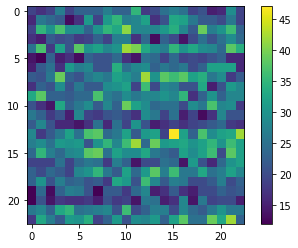

In [32]:
plt.imshow(conf_mat.sum(-1).sum(-1));plt.colorbar()

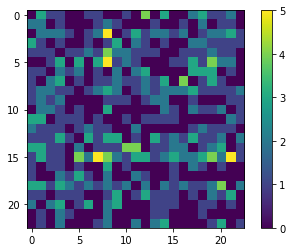

In [34]:
plt.imshow(conf_mat[:,:,0,0] + conf_mat[:,:,1:,0].sum(2)); plt.colorbar();

(1, 23, 23, 12, 25)
(12,)
(25,)
0.04414869124961836 0.04414869124961836 (25, 1001)
(1, 23, 23, 12, 25)
(12,)
(275,)
0.04430066531720682 0.044300665317206826 (25, 1001)
(1, 23, 23, 12, 25)
(12,)
(300,)
0.044288000811574454 0.04428800081157445 (25, 1001)
(1, 23, 23, 12, 25)
(12,)
(25,)
0.04384635568471423 0.04384635568471423 (25, 1001)
(1, 23, 23, 12, 25)
(12,)
(275,)
0.03757821892771183 0.03757821892771183 (25, 1001)
(1, 23, 23, 12, 25)
(12,)
(300,)
0.038100563657462026 0.03810056365746203 (25, 1001)


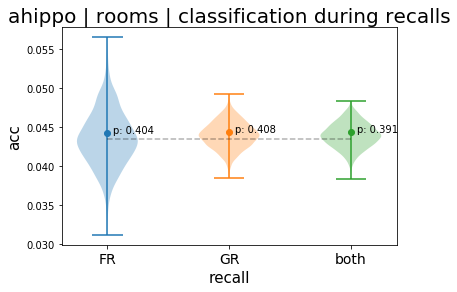

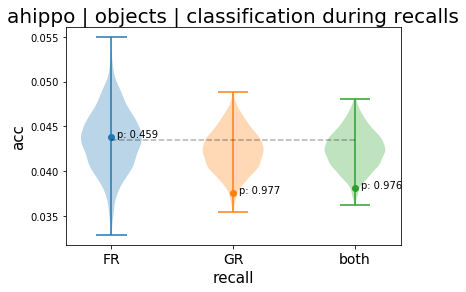

In [256]:
trials = ['GR0', 'GR1', 'GR2', 'GR3','GR4', 'GR5', 'GR6', 'GR7','GR8', 'GR9', 'GR10','FR']

for beta2use in ['rooms','objects']:
    
    plt.figure()
    for t2u, trial_to_use in enumerate(['FR','GR','both']):
        
        if trial_to_use == 'FR':
            trials_to_use = [np.arange(len(trials))[-1]]
        elif trial_to_use == 'GR':
            trials_to_use = np.arange(len(trials))[:-1]
        elif trial_to_use =='both':
            trials_to_use = np.arange(len(trials))

        print(hippo_recall_scores[beta2use]['conf_mat']['None'].shape)
        conf_mat = hippo_recall_scores[beta2use]['conf_mat']['None'].squeeze()[:,:,:,:]
#         conf_acc = conf_mat.sum(-1).sum(-1)[np.eye(23,dtype=bool)].sum() / conf_mat.sum()
        
#         conf_acc = []
#         for i in range(12):
#             temp_confmat = conf_mat[:,:,i,:]
#             conf_acc.append(temp_confmat.sum(-1)[np.eye(23,dtype=bool)].sum() / temp_confmat.sum())
#         print(np.shape(conf_acc))
#         conf_acc = np.mean(np.array(conf_acc)[trials_to_use])
        
        conf_acc = []
        for i in trials_to_use:
            for j in range(25):
                temp_confmat = conf_mat[:,:,i,j]
                conf_acc.append(temp_confmat[np.eye(23,dtype=bool)].sum() / temp_confmat.sum())
        print(np.shape(conf_acc))
#         conf_acc = np.mean(np.array(conf_acc)[trials_to_use])
        conf_acc = np.mean(np.array(conf_acc))
        
#         conf_acc = np.nanmean(hippo_recall_scores[beta2use]['conf_mat']['None'].squeeze()[trials_to_use,:,:],0).mean(0)

        trial_acc = np.nanmean(hippo_recall_scores[beta2use]['accuracy']['None'].squeeze()[trials_to_use,:,:],0) #select trials

        print(conf_acc, trial_acc[:,0].mean(), trial_acc.shape)
        
        trial_acc_mean = trial_acc[:,1:].mean(0) # averageout subj
        
        trialaccs = trial_acc[:,:].mean(0) #keep 1001
        
        ## get p-value
        sided = 1        
        thesum = np.sum(np.abs(trialaccs)>=np.abs(trialaccs[0])) if sided==2 else np.sum((trialaccs[:])>=(trialaccs[0]))
        p = (thesum/(1001))  #turn to fraction
        
#         p = stats.norm.sf()

        plt.violinplot(trial_acc_mean,positions=[t2u+1])
        plt.scatter(t2u+1,trial_acc[:,0].mean())
        plt.annotate('p: {:.3f}'.format(p), (t2u+1+0.05, trial_acc[:,0].mean()))
        
    plt.xticks(range(1,4),['FR','GR','both'],fontsize=14)
    plt.title("{} | {} | classification during recalls".format(roi,beta2use),fontsize=20)
    plt.xlabel('recall',fontsize=15);plt.ylabel("acc",fontsize=15)
    plt.hlines(1/23,1,3,linestyle='--',alpha=.3)




In [252]:
trials_to_use

[11]

# hippo RIPs

/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

...BETATYPE:  objects


/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  None


/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

...BETATYPE:  rooms


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

..... hippo
hippo rooms
.... t: 0.383 | p: 0.705
0.045968591593868346 0.043478260869565216
hippo objects
.... t: -0.833 | p: 0.413
0.041598398590267774 0.043478260869565216


/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/jukebox/pkgs/PYGER/0.9.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


  0%|          | 0/2 [00:00<?, ?it/s]

...BETATYPE:  objects


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

...BETATYPE:  rooms


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

..... ahippo
ahippo rooms
.... t: 0.611 | p: 0.547
0.044292121118908796 0.043478260869565216
ahippo objects
.... t: -0.085 | p: 0.933
0.04246076973210334 0.043478260869565216


  0%|          | 0/2 [00:00<?, ?it/s]

...BETATYPE:  objects


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

...BETATYPE:  rooms


  0%|          | 0/1 [00:00<?, ?it/s]

............MEASURE:  RIPs
...............HEM:  None


  0%|          | 0/1 [00:00<?, ?it/s]

..... phippo
phippo rooms
.... t: 0.358 | p: 0.724
0.04439920435574278 0.043478260869565216
phippo objects
.... t: 0.316 | p: 0.755
0.043067353792512864 0.043478260869565216


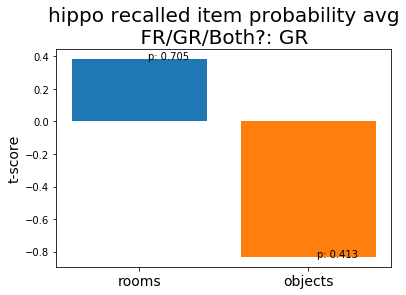

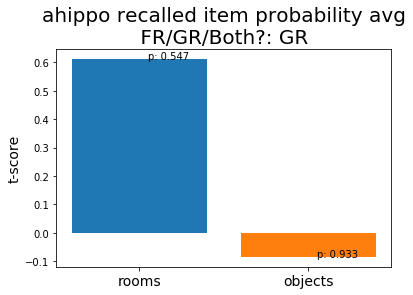

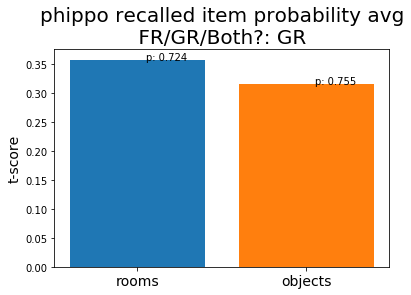

In [174]:
trial_to_use = 'GR'
if trial_to_use == 'FR':
    trials_to_use = [np.arange(len(trials))[-1]]
elif trial_to_use == 'GR':
    trials_to_use = np.arange(len(trials))[:-1]
elif trial_to_use =='both':
    trials_to_use = np.arange(len(trials))

date = 20240108; shift = 4; win_size = 9;

# betatypes = ['rooms','objects']
betatypes = ['objects', 'rooms'] #['objects']
roi = 'ahippo' # <--------- CHANGE THIS to see results for other HIPPO ROIs
hems = ['None']
measure_list = [
#     'evidence',
#     'accuracy', #
#     'RIP_window', # 
    'RIPs',
#     'conf_mat', #  
  ]


for hipporoi in ['hippo','ahippo','phippo']:
    hippo_recall_scores = GetRecallEvidence(date, hipporoi, shift, win_size, measure_list, betatypes, hems=hems)
    plt.figure()
    print('.....', hipporoi)
    for bi,beta2use in enumerate(['rooms','objects']):
        curr_rip = np.nanmean(hippo_recall_scores[beta2use]['RIPs']['None'].squeeze()[trials_to_use],1) #.mean(1).mean(1)
        all_rips = curr_rip.ravel()
        all_rips = np.nanmean(curr_rip,0)
        
        t,p = stats.ttest_1samp(all_rips[~np.isnan(all_rips)],1/23)
        print(hipporoi, beta2use)
        print('.... t: {:.3f} | p: {:.3f}'.format(t, p))

        
        x = np.nanmean(np.nanmean(hippo_recall_scores[beta2use]['RIPs']['None'].squeeze(),1),1) #.mean(1).mean(1)
        print(x.mean(), 1/23)
        
        plt.bar(bi,t)
        plt.annotate('p: {:.3f}'.format(p), (bi+0.05, t))
        
#         plt.violinplot(trial_acc_mean,positions=[t2u+1])
#         plt.scatter(t2u+1,trial_acc[:,0].mean())
#         plt.annotate('p: {:.3f}'.format(p), (t2u+1+0.05, trial_acc[:,0].mean()))
        
    plt.xticks(range(0,2),['rooms','objects'],fontsize=14)
    plt.title("{} recalled item probability avg\n FR/GR/Both?: {} ".format(hipporoi,trial_to_use),fontsize=20)
#     plt.xlabel('recall',fontsize=15);plt.ylabel("acc",fontsize=15)
#     plt.hlines(1/23,1,3,linestyle='--',alpha=.3)
    plt.ylabel("t-score", fontsize=14)




In [153]:
curr_rip.shape

(23, 25)